# Protify Rotation Demo

This notebook demonstrates how to use **Protify** to:

1. Download and process TESS light curves
2. Compute periodograms and extract rotation periods
3. Summarize and classify rotators using a trained model

 **Note**: This example uses stars from the training set for demonstration only.


## Imports

In [1]:
import pandas as pd
from protify.runner import run_period_pipeline
from protify.classifier import generate_summary_from_raw, run_classifier

## Load Example Input

In [4]:
input_csv = 'sample_input.csv' #assuming it's in the same examples directory
df = pd.read_csv(input_csv)
df.head()


,TIC,provenance,gmag
0,401834404,mearth,12.884933
1,397046970,Hyades,10.391185
2,435881860,Hyades,11.770583


## Run Period Analysis

In [13]:
run_period_pipeline(
    input_csv=input_csv,
    raw_output_csv='rotation_raw.csv',
    save_lc_pickle=True,
    save_plots=True,
    pickle_dir='../lightcurves',
    plot_dir='../plots'
)


Starting TIC 401834404...
  Found 17 sectors.
No output of frequency error.
Increase frequency range to sample the peak maximum.
  Done in 111.64s (~6.57 s/sector)
Starting TIC 397046970...
  Found 6 sectors.
  Done in 13.43s (~2.24 s/sector)
Starting TIC 435881860...
  Found 18 sectors.
No output of frequency error.
Increase frequency range to sample the peak maximum.
No output of frequency error.
Increase frequency range to sample the peak maximum.
  Done in 51.08s (~2.84 s/sector)

✅ Saved all results to rotation_raw.csv with updated columns.


## Plot an Example Star

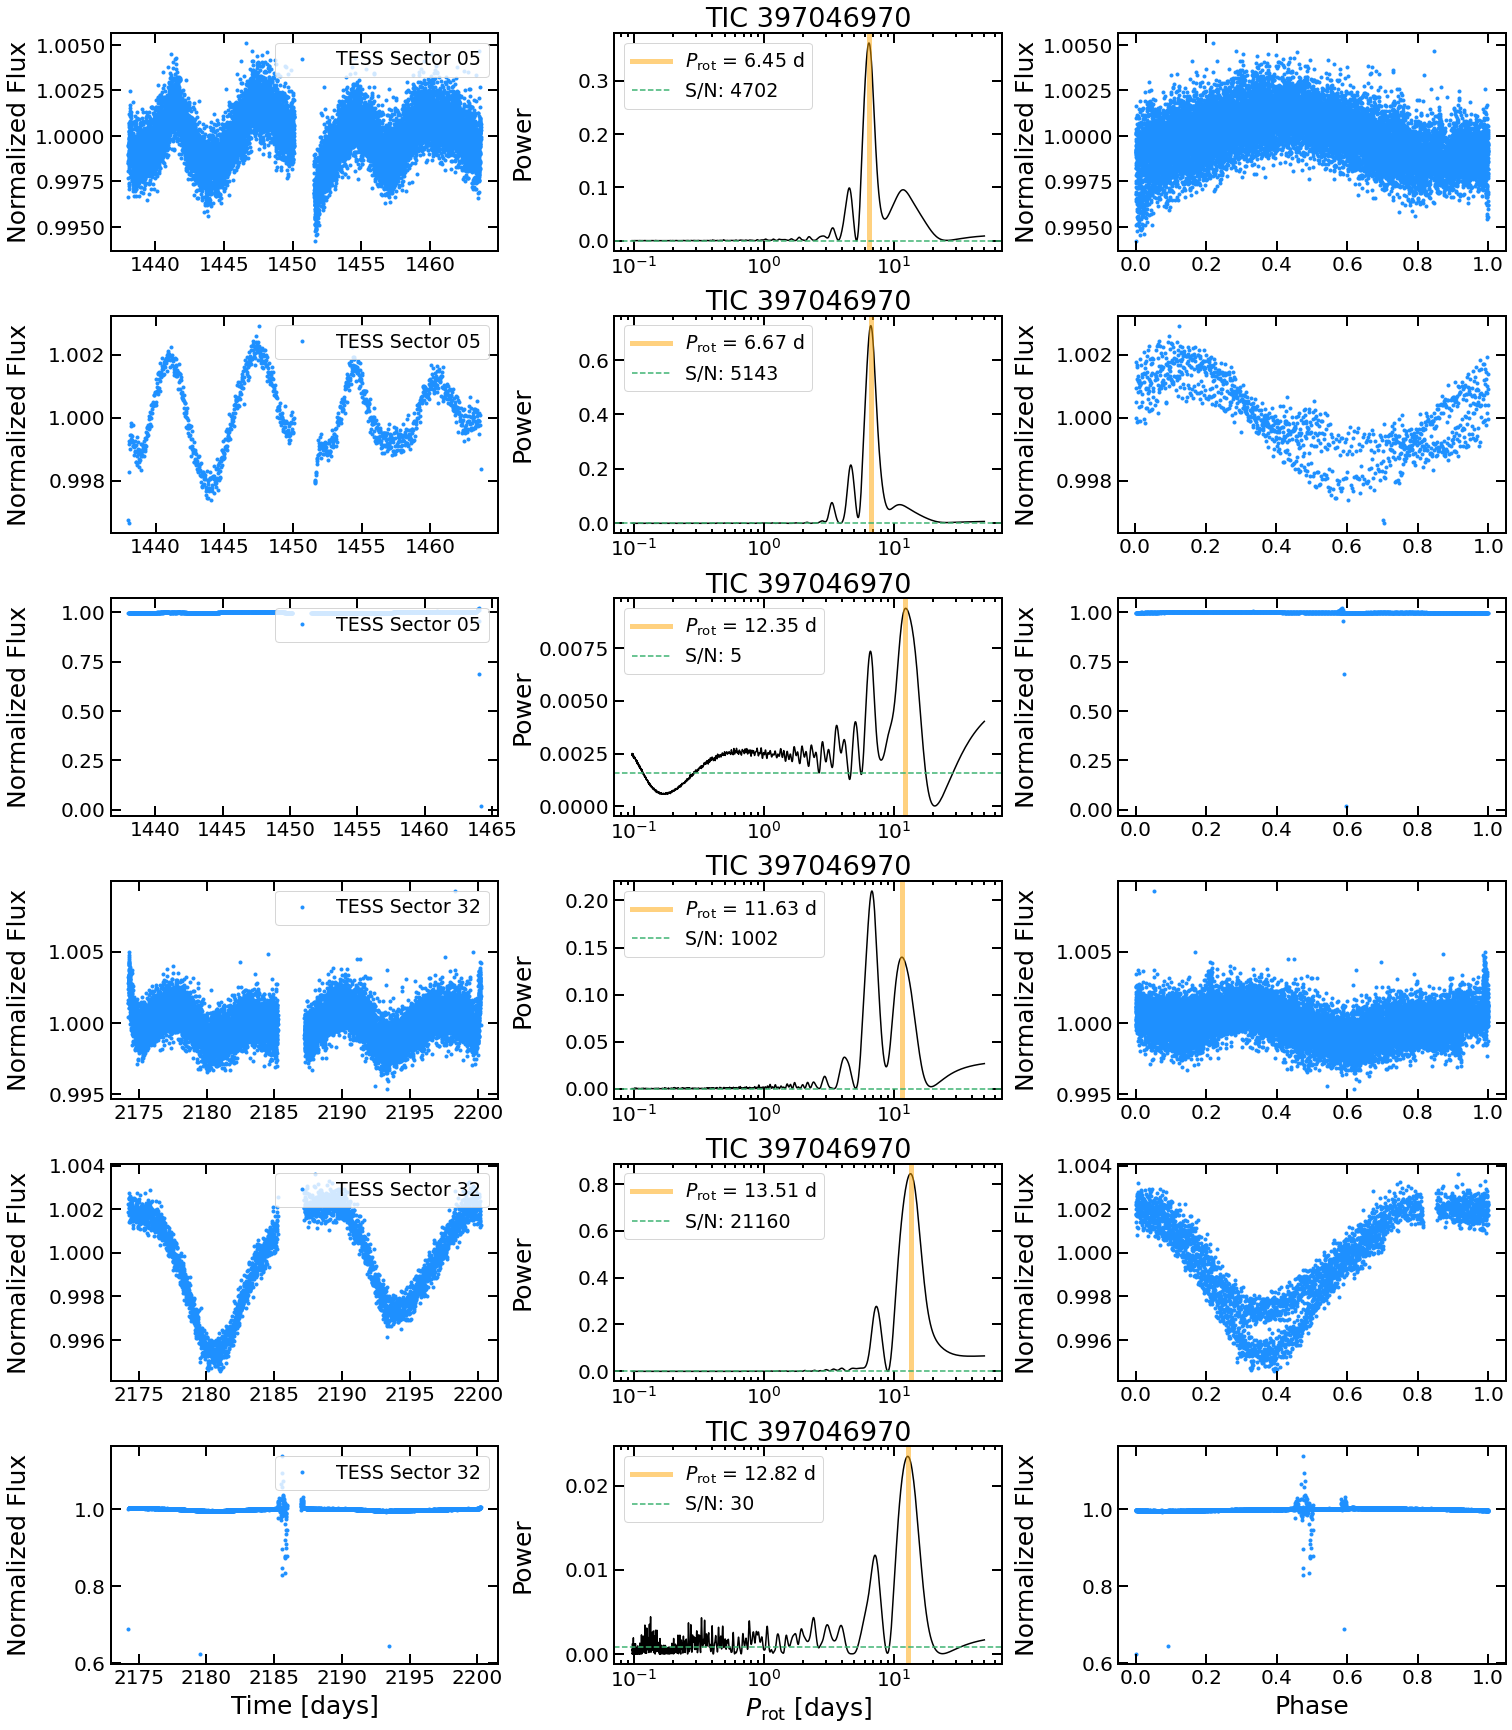

In [17]:
import pickle
from protify.plotting import extract_sector_metrics, plot_lightcurve_summary
import os

# Pick a TIC to load (use the first file in the pickle dir)
pickle_files = sorted(os.listdir("../lightcurves"))
if pickle_files:
    sample_file = os.path.join("../lightcurves", pickle_files[1])
    with open(sample_file, "rb") as f:
        star_data = pickle.load(f)

    # Extract metrics and plot
    prots, medps, powers, uncs, snrs, times, fluxes, pgramxs, pgramys, sectors = extract_sector_metrics(star_data)
    plot_lightcurve_summary(
        times=times,
        fluxes=fluxes,
        pgramxs=pgramxs,
        pgramys=pgramys,
        prots=prots,
        medps=medps,
        powers=powers,
        sectors=sectors,
        tic_ids=[star_data["TIC"]] * len(prots)
    )
else:
    print("No pickle files found in 'lightcurves/' — run the pipeline with save_lc_pickle=True.")


## Summarize Rotation Metrics

In [6]:
generate_summary_from_raw(
    raw_csv_path='rotation_raw.csv',
    out_csv_path='rotation_summary.csv',
    autoval_only=True
)


Final summary per star:
401834404 | Prot: 6.290 | SNR: 554.06 | Power: 0.14 | MedPower: 0.00 | FracUnc: 0.098
397046970 | Prot: 9.147 | SNR: 8002.34 | Power: 0.52 | MedPower: 0.00 | FracUnc: 0.161
435881860 | Prot: 5.842 | SNR: 426.67 | Power: 0.09 | MedPower: 0.00 | FracUnc: 0.108
Saved summary to rotation_summary.csv


##  Classify Likely Rotators

In [9]:
run_classifier(
    input_file='rotation_summary.csv',
    train_file='../protify/data/RotatorTrainingSet.csv',
    output_file='rotation_classified.csv',
    use_autoval=True
)


Classification results (rotate? = 1 means rotator):
TIC 401834404 | rotate?: 0.0 | Prob: 0.349
  ⚠️  Not flagged as rotator. Features:
prot        6.289557
snr       554.060744
power       0.140878
mpower      0.000328
func        0.578391
gmag       12.884933
Name: 0, dtype: object
TIC 397046970 | rotate?: 1.0 | Prob: 0.691
TIC 435881860 | rotate?: 0.0 | Prob: 0.402
  ⚠️  Not flagged as rotator. Features:
prot        5.842391
snr       426.667535
power       0.092411
mpower      0.000252
func        0.900167
gmag       11.770583
Name: 2, dtype: object


## View Final Output

In [10]:
classified_df = pd.read_csv('rotation_classified.csv')
classified_df[['TIC', 'prot', 'rotation_prob', 'rotate?']].head()

,TIC,prot,rotation_prob,rotate?
0,401834404,6.289557,0.348889,0.0
1,397046970,9.147287,0.691111,1.0
2,435881860,5.842391,0.401728,0.0
